In [32]:
# importing packages and modules
import numpy as np
#import autograd.numpy as jnp
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import minimize, check_grad
from utils import *
from plotting_utils import *
from analysis_utils import *
import dglm_hmm1
from scipy.stats import multivariate_normal, norm
#from autograd import value_and_grad

colormap = ['rebeccapurple','teal','darkturquoise','springgreen']
sns.set_context("talk")

In [33]:
# setting hyperparameters
S = 20 # sessions
T = 500 # trials per session
N = T * S # total data points
C = 2 # classes
K = 2 # states
D = 2 # features (sensory & bias)

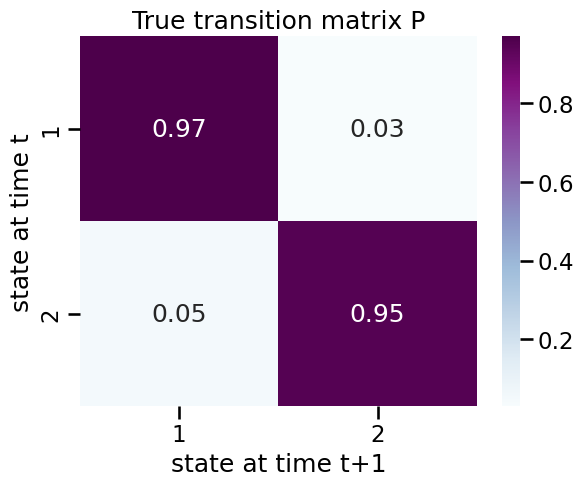

In [34]:
# True Transition Matrix
trueP = np.zeros((2,2))
trueP[0,0]=0.97
trueP[0,1]=0.03
trueP[1,0]=.05
trueP[1,1]=.95
plot_transition_matrix(trueP, title='True')
plt.savefig(f'../figures_M1/TrueP_2-state.png', bbox_inches='tight', dpi=400)

In [35]:
# true intial latent state distribution
truepi = np.ones((K))/K
print(truepi)

[0.5 0.5]


Session indicies
[0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000, 9500, 10000]
(10000, 2, 2, 2)


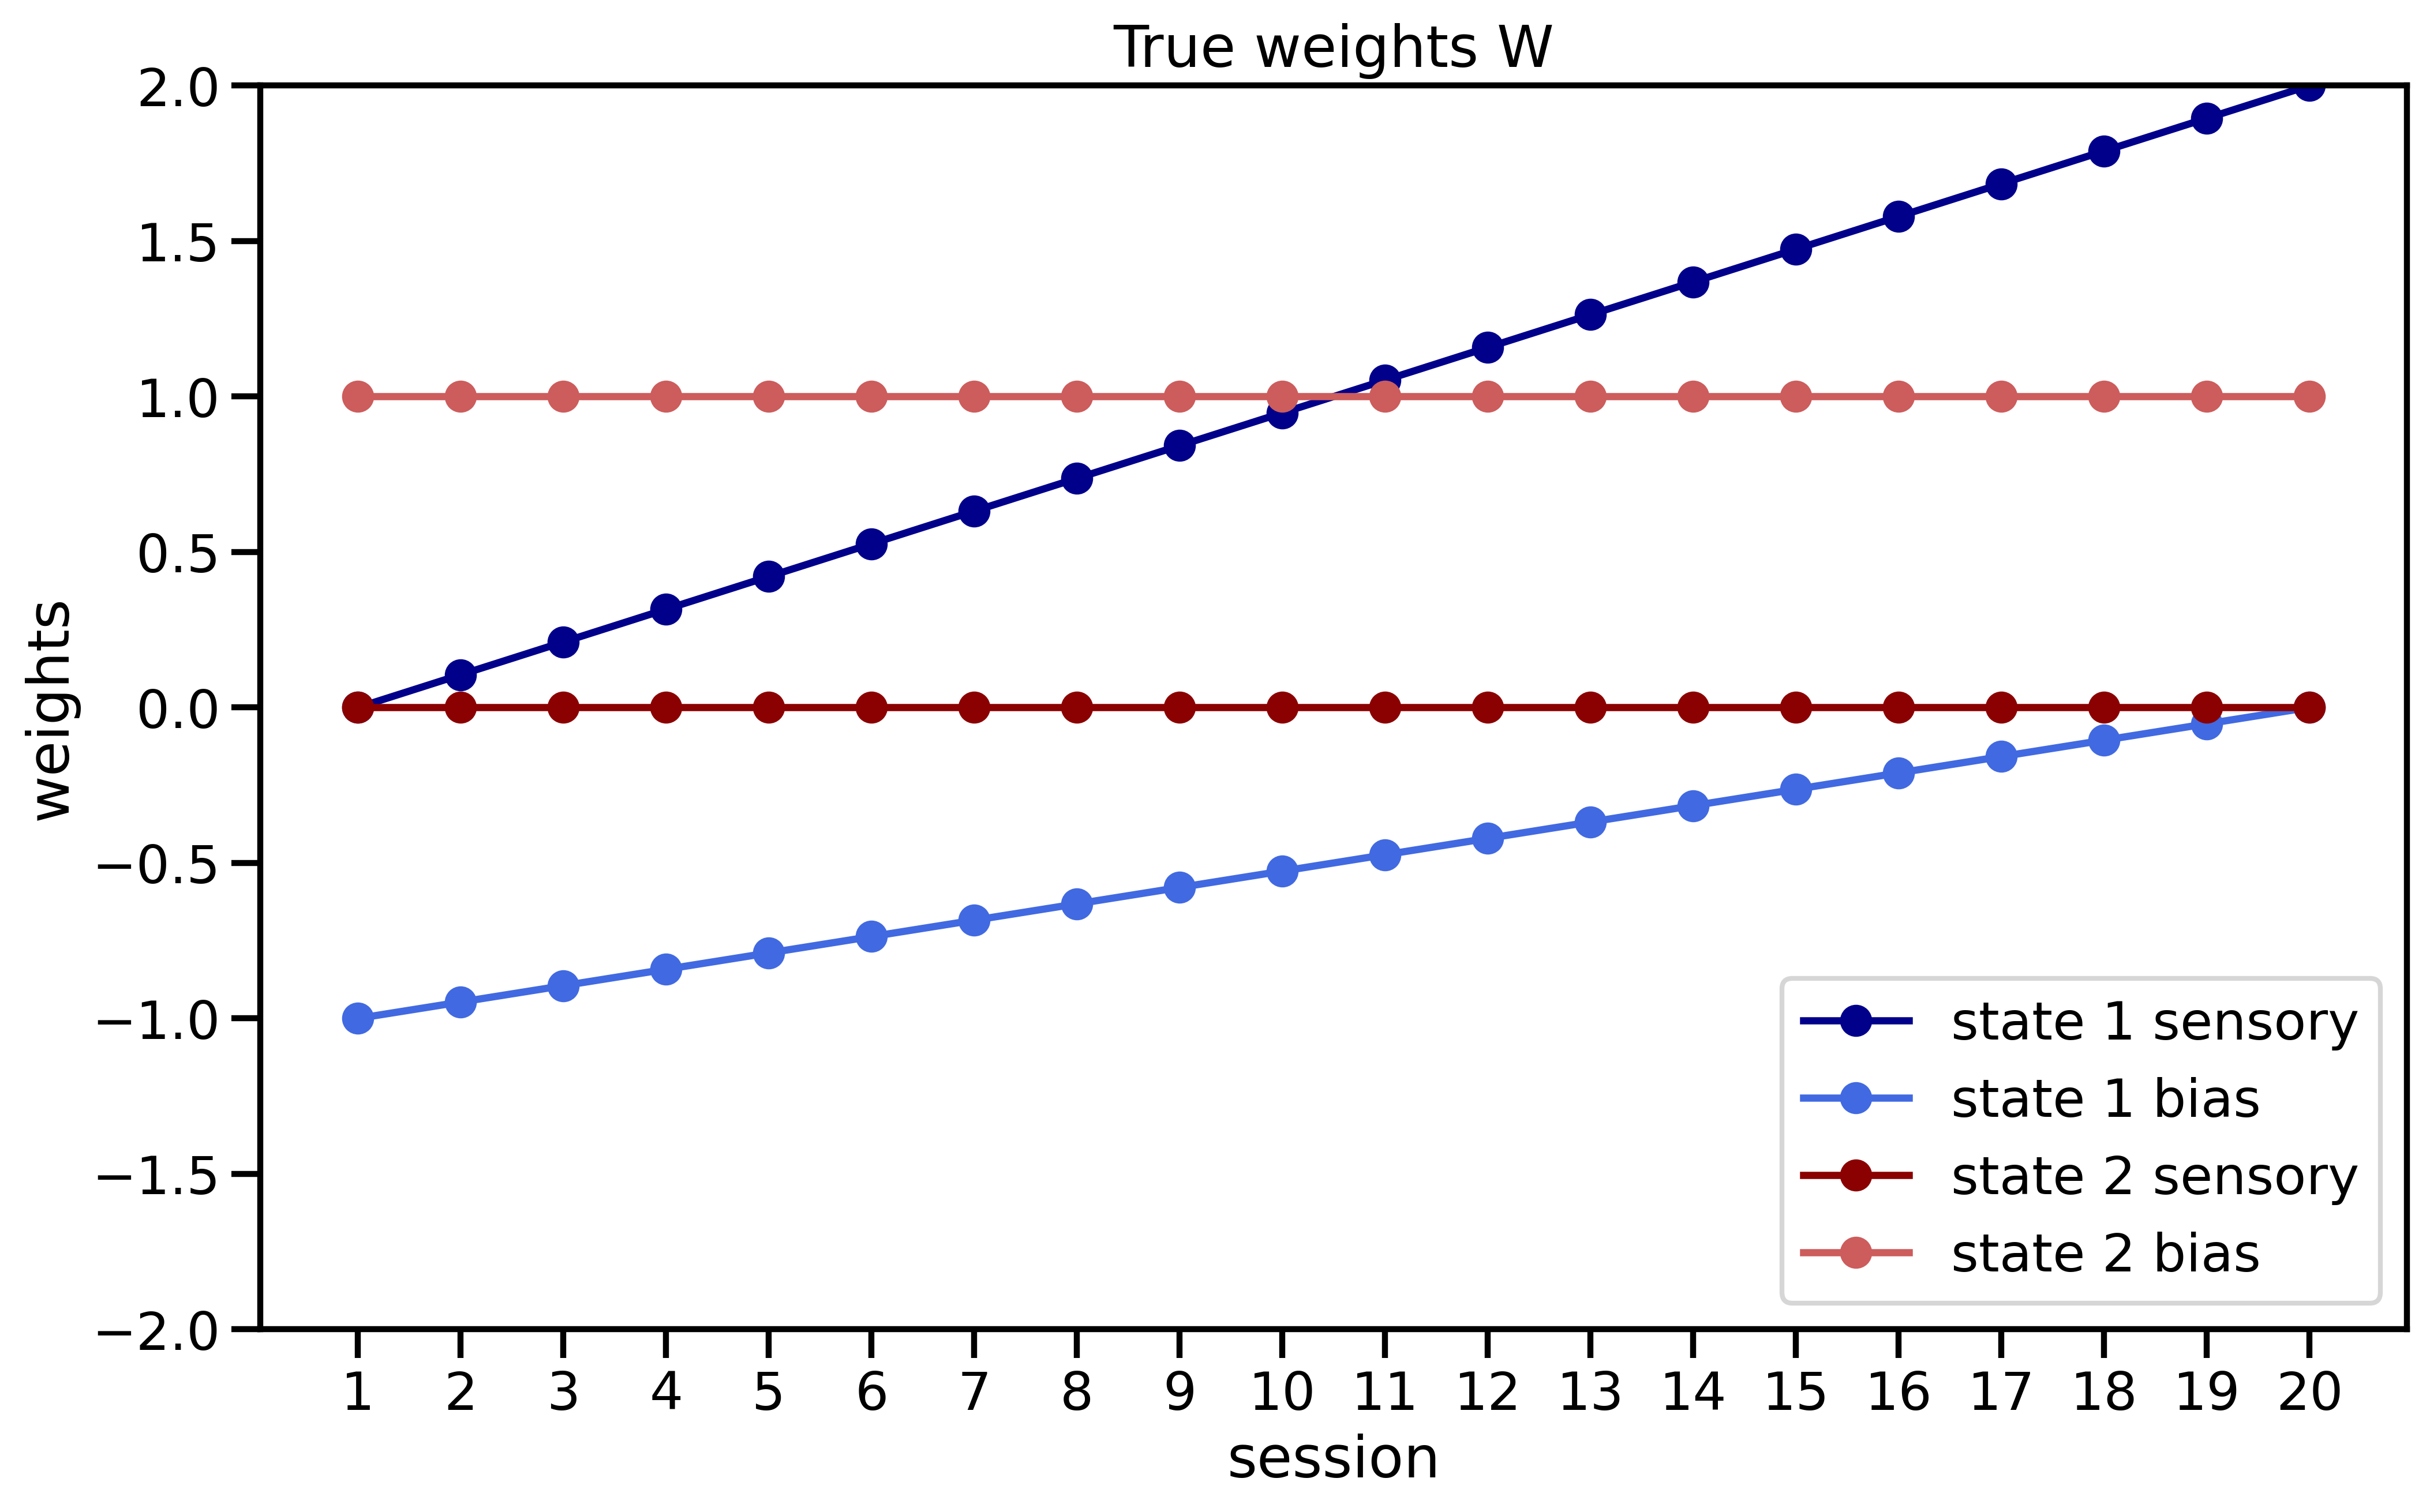

In [36]:
# True Weights and Session Start Indices
ourW = np.zeros((S,K,D))
ourW[:,0,1] = np.linspace(0,2,S) # state 1 sensory (increasing)
ourW[:,0,0] = np.linspace(-1,0,S) # state 1 bias (decreasing)
ourW[:,1,1] = 0 # state 2 sensory (flat 0)
ourW[:,1,0] = 1 # state 2 bias (flat 1)
trueW = np.zeros((N,K,D,C))
# change weight format to have session*trials points
sessInd = []
for sess in range(0,S):
    sessInd.append(sess*T)
    for t in range(0,T):
        trueW[sess*T+t,:,:,1] = ourW[sess,:,:]
sessInd.append(N)
print("Session indicies")
print(sessInd)

print(trueW.shape)
fig, axes = plt.subplots(1, figsize = (12,7), dpi=400)
plotting_weights(w=trueW, sessInd=sessInd, axes=axes, trueW=None, title='True weights W', save_fig=False)
axes.set_ylim(-2,2)
plt.savefig(f'../figures_M1/TrueW_2-state.png', bbox_inches='tight', dpi=400)

In [37]:
dGLM_HMM = dglm_hmm1.dGLM_HMM1(N,K,D,C)
# x, y, _ = dGLM_HMM.simulate_data(trueW, trueP, truepi, sessInd, save=True, title=f'/N={N}_{K}_state_constant-drift_')
x = np.load(f'../data_M1/N={N}_{K}_state_constant-drift_x.npy')
y = np.load(f'../data_M1/N={N}_{K}_state_constant-drift_y.npy')

# CV Fitting

In [25]:
splitFolds = 5
presentTrain, presentTest = split_data(N, sessInd, folds=5, blocks=10, random_state=1)

sigmaList = [0] + [2**x for x in list(np.arange(-10,-4,1,dtype=float))] + [2**x for x in list(np.arange(-4,1,0.5,dtype=float))] + [2**x for x in list(np.arange(1,8,2,dtype=float))]
maxiter = 250
fit_init_states=False

allP = np.zeros((splitFolds, len(sigmaList), K, K))
allpi = np.zeros((splitFolds, len(sigmaList), K))
allW = np.zeros((splitFolds, len(sigmaList), N, K, D, C))
# trainLl = np.zeros((splitFolds, len(sigmaList), maxiter))
testLl = np.zeros((splitFolds, len(sigmaList)))
testAccuracy = np.zeros((splitFolds, len(sigmaList)))

for fold in range(0, splitFolds):
    print("Fold ",fold)
    # fitting 
    allP[fold], allpi[fold], allW[fold], _, testLl[fold], testAccuracy[fold] = fit_eval_CV_multiple_sigmas(K, x, y, sessInd, presentTrain[fold], presentTest[fold], sigmaList=sigmaList, maxiter=maxiter, glmhmmW=None, glmhmmP=None, L2penaltyW=1, priorDirP=None, fit_init_states=fit_init_states)

# saving 
np.save(f'../data_M1/N={N}_{K}_P_CV_sigma1D_simulated_data', allP)
np.save(f'../data_M1/N={N}_{K}_W_CV_sigma1D_simulated_data', allW)
np.save(f'../data_M1/N={N}_{K}_testLl_CV_sigma1D_simulated_data', testLl)
np.save(f'../data_M1/N={N}_{K}_testAccuracy_CV_sigma1D_simulated_data', testAccuracy)




Fold  0
Fold  1
Fold  2
Fold  3
Fold  4


In [7]:
# indSigma = 9
# for fold in range(0, splitFolds):
#     sortedStateInd = get_states_order(allW[fold, indSigma], sessInd, stimCol=[1])
#     fig, axes = plt.subplots()
#     plot_transition_matrix(allP[fold, indSigma], f'recovered P for sigma={np.round(sigmaList[indSigma],2)} fold {fold}', sortedStateInd=sortedStateInd)
#     fig, axes = plt.subplots(1, figsize = (14,8), dpi=400)
#     plotting_weights(allW[fold, indSigma], sessInd, axes=axes,  trueW=trueW, title=f'Recovered weights for sigma={np.round(sigmaList[indSigma],2)} fold {fold}', save_fig=False, sortedStateInd=sortedStateInd)

# Fitting different number of states K

In [38]:
splitFolds = 5
presentTrain, presentTest = split_data(N, sessInd, folds=5, blocks=10, random_state=1)

sigmaList = [0] + [2**x for x in list(np.arange(-10,-4,1,dtype=float))] + [2**x for x in list(np.arange(-4,1,0.5,dtype=float))] + [2**x for x in list(np.arange(1,8,2,dtype=float))]
maxiter = 250
fit_init_states=False

for K in [1,3]:

    allP = np.zeros((splitFolds, len(sigmaList), K, K))
    allpi = np.zeros((splitFolds, len(sigmaList), K))
    allW = np.zeros((splitFolds, len(sigmaList), N, K, D, C))
    # trainLl = np.zeros((splitFolds, len(sigmaList), maxiter))
    testLl = np.zeros((splitFolds, len(sigmaList)))
    testAccuracy = np.zeros((splitFolds, len(sigmaList)))

    for fold in range(0, splitFolds):
        print("Fold ",fold)
        # fitting 
        allP[fold], allpi[fold], allW[fold], _, testLl[fold], testAccuracy[fold] = fit_eval_CV_multiple_sigmas(K, x, y, sessInd, presentTrain[fold], presentTest[fold], sigmaList=sigmaList, maxiter=maxiter, glmhmmW=None, glmhmmP=None, L2penaltyW=1, priorDirP=None, fit_init_states=fit_init_states)

    # saving 
    np.save(f'../data_M1/N={N}_K={K}_P_CV_sigma1D_simulated_data_2-state', allP)
    np.save(f'../data_M1/N={N}_K={K}_W_CV_sigma1D_simulated_dat_2-statea', allW)
    np.save(f'../data_M1/N={N}_K={K}_testLl_CV_sigma1D_simulated_data_2-state', testLl)
    np.save(f'../data_M1/N={N}_K={K}_testAccuracy_CV_sigma1D_simulated_data_2-state', testAccuracy)

Fold  0
Fold  1
Fold  2
Fold  3
Fold  4
Fold  0
Fold  1
Fold  2
Fold  3
Fold  4


# Investigating Test Log-Likelihood

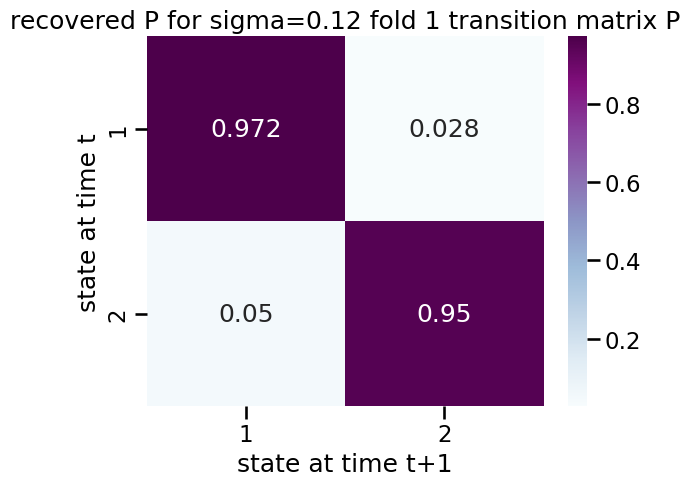

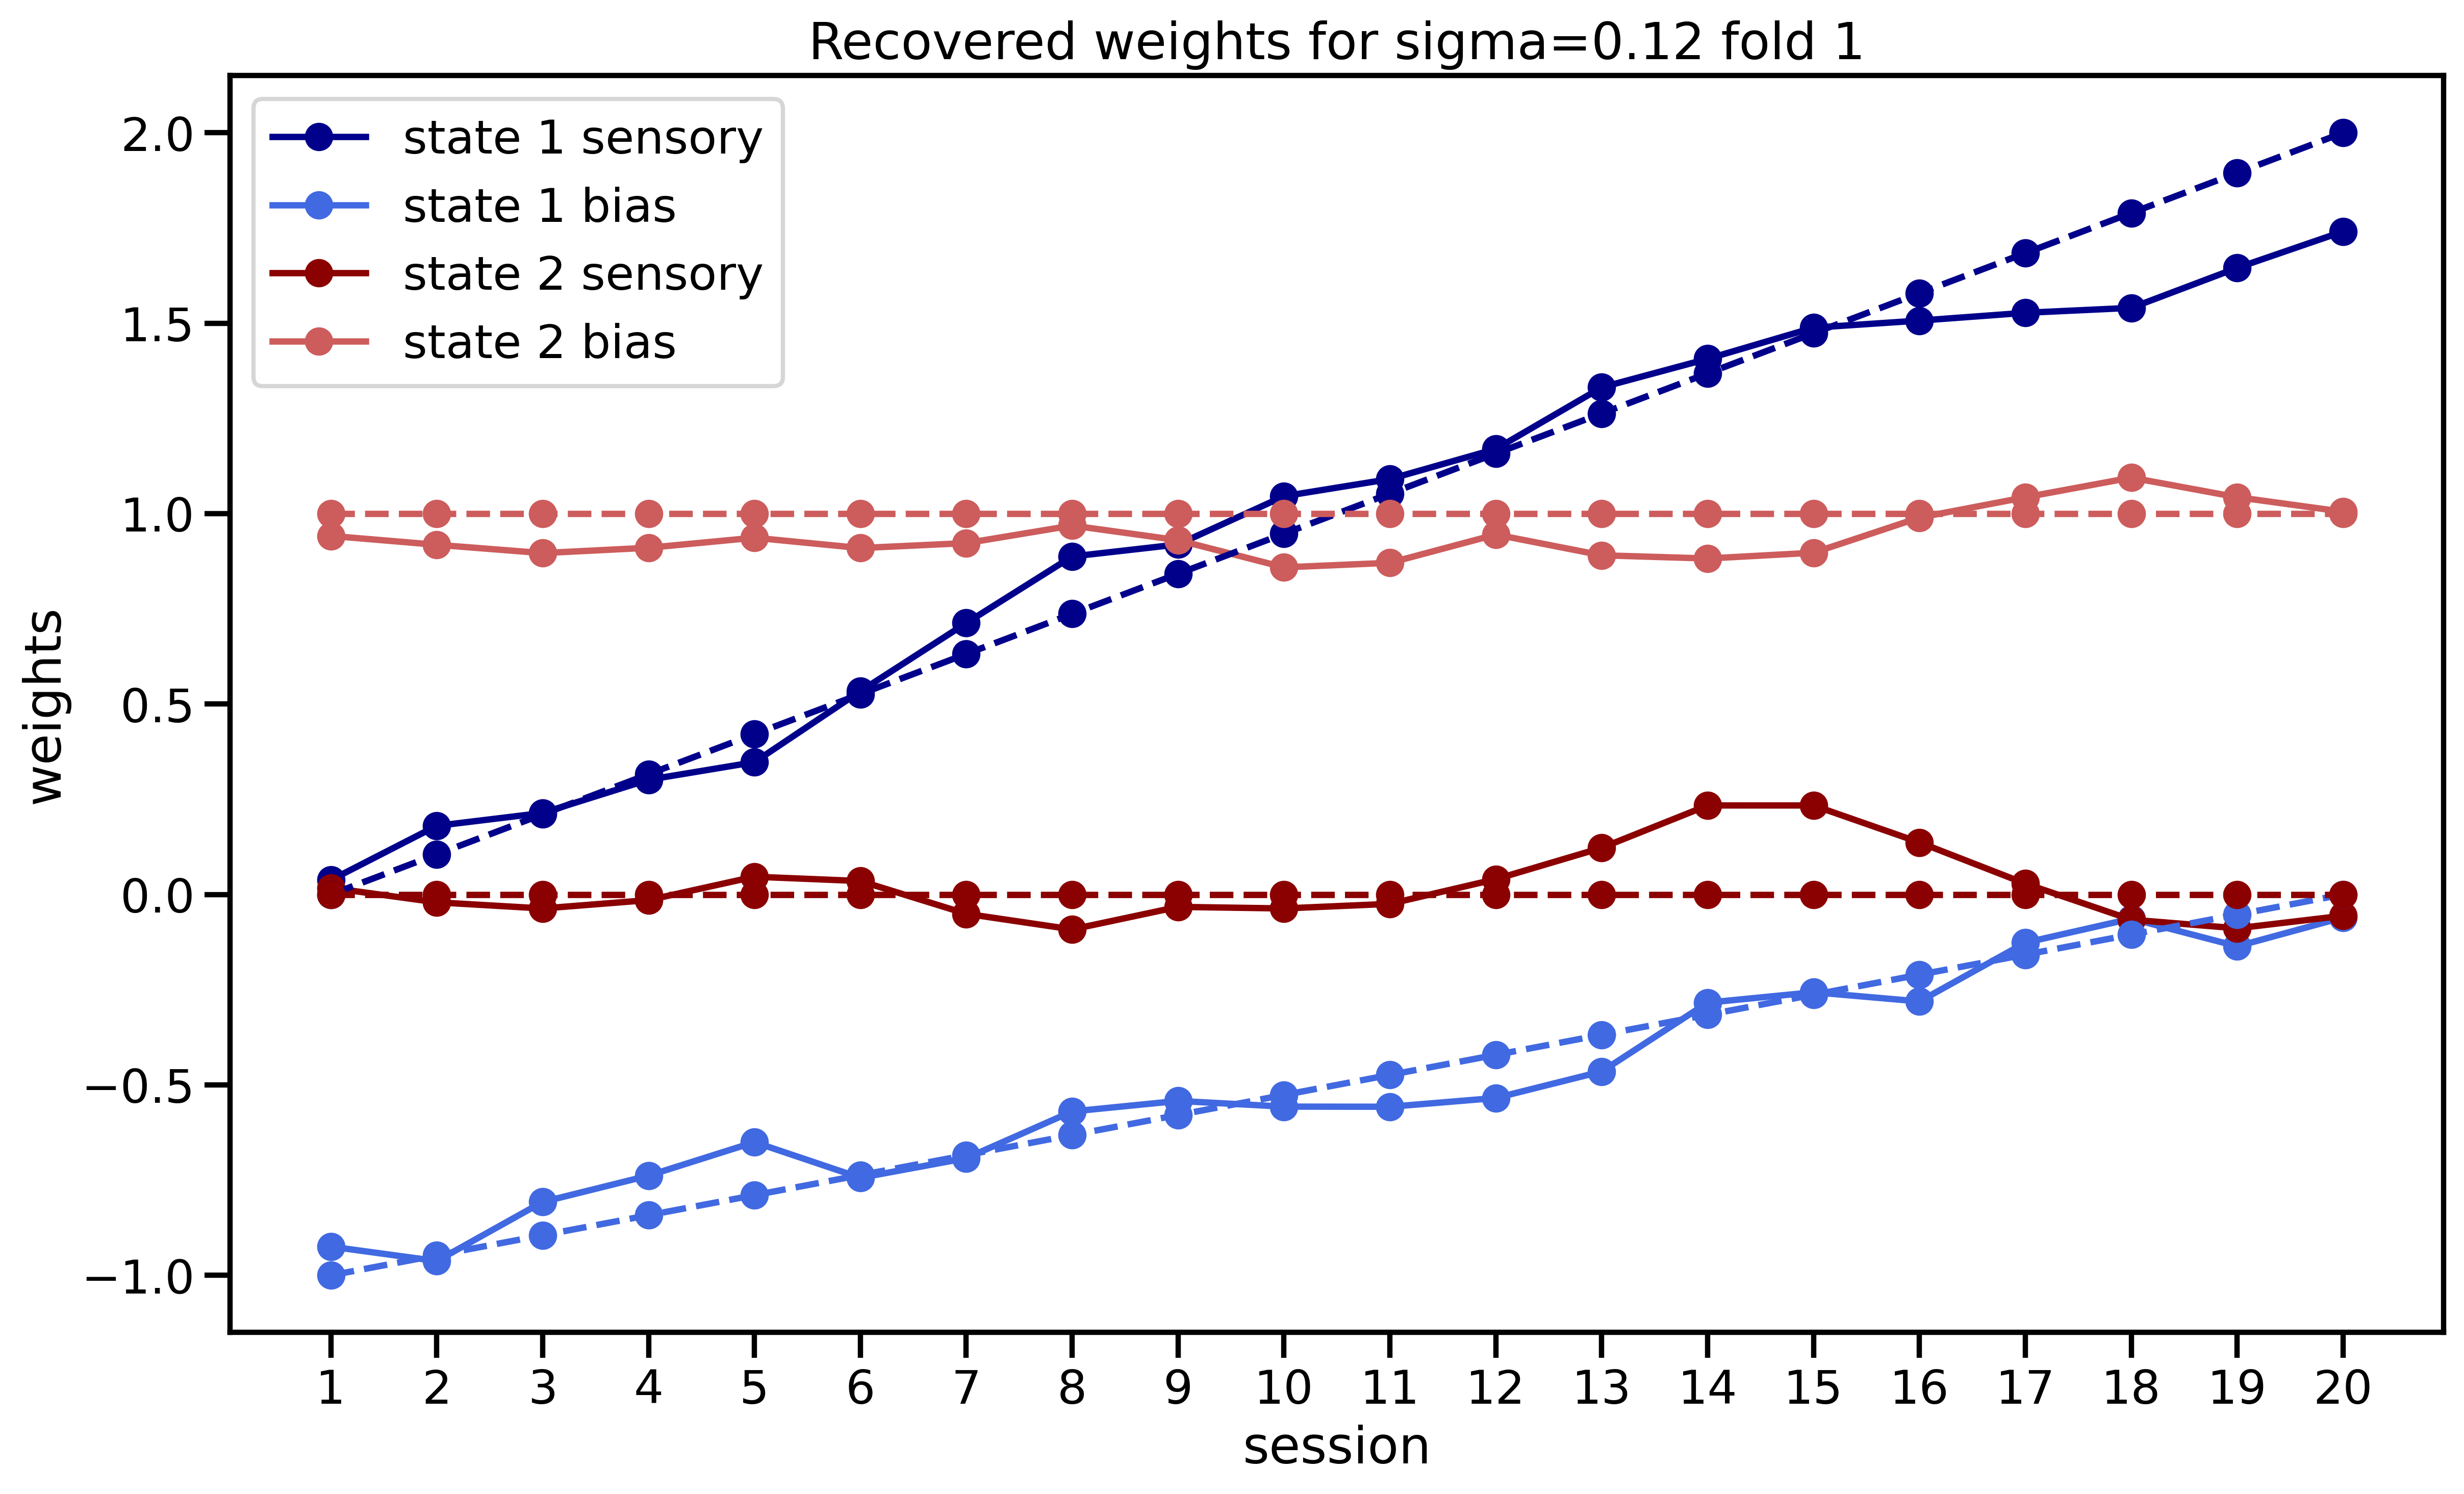

In [9]:
splitFolds = 5
sigmaList = [0] + [2**x for x in list(np.arange(-10,-4,1,dtype=float))] + [2**x for x in list(np.arange(-4,1,0.5,dtype=float))] + [2**x for x in list(np.arange(1,8,2,dtype=float))]
allP = np.load(f'../data_M1/N={N}_{K}_P_CV_sigma1D_simulated_data.npy')
allW = np.load(f'../data_M1/N={N}_{K}_W_CV_sigma1D_simulated_data.npy')
testLl = np.load(f'../data_M1/N={N}_{K}_testLl_CV_sigma1D_simulated_data.npy')
testAccuracy = np.load(f'../data_M1/N={N}_{K}_testAccuracy_CV_sigma1D_simulated_data.npy')

indSigma = 9
for fold in [1]:#range(0, splitFolds):
    sortedStateInd = get_states_order(allW[fold, indSigma], sessInd, stimCol=[1])
    fig, axes = plt.subplots()
    plot_transition_matrix(allP[fold, indSigma], f'recovered P for sigma={np.round(sigmaList[indSigma],2)} fold {fold}', sortedStateInd=sortedStateInd)
    fig, axes = plt.subplots(1, figsize = (14,8), dpi=400)
    plotting_weights(allW[fold, indSigma], sessInd, axes=axes,  trueW=trueW, title=f'Recovered weights for sigma={np.round(sigmaList[indSigma],2)} fold {fold}', save_fig=False, sortedStateInd=sortedStateInd)

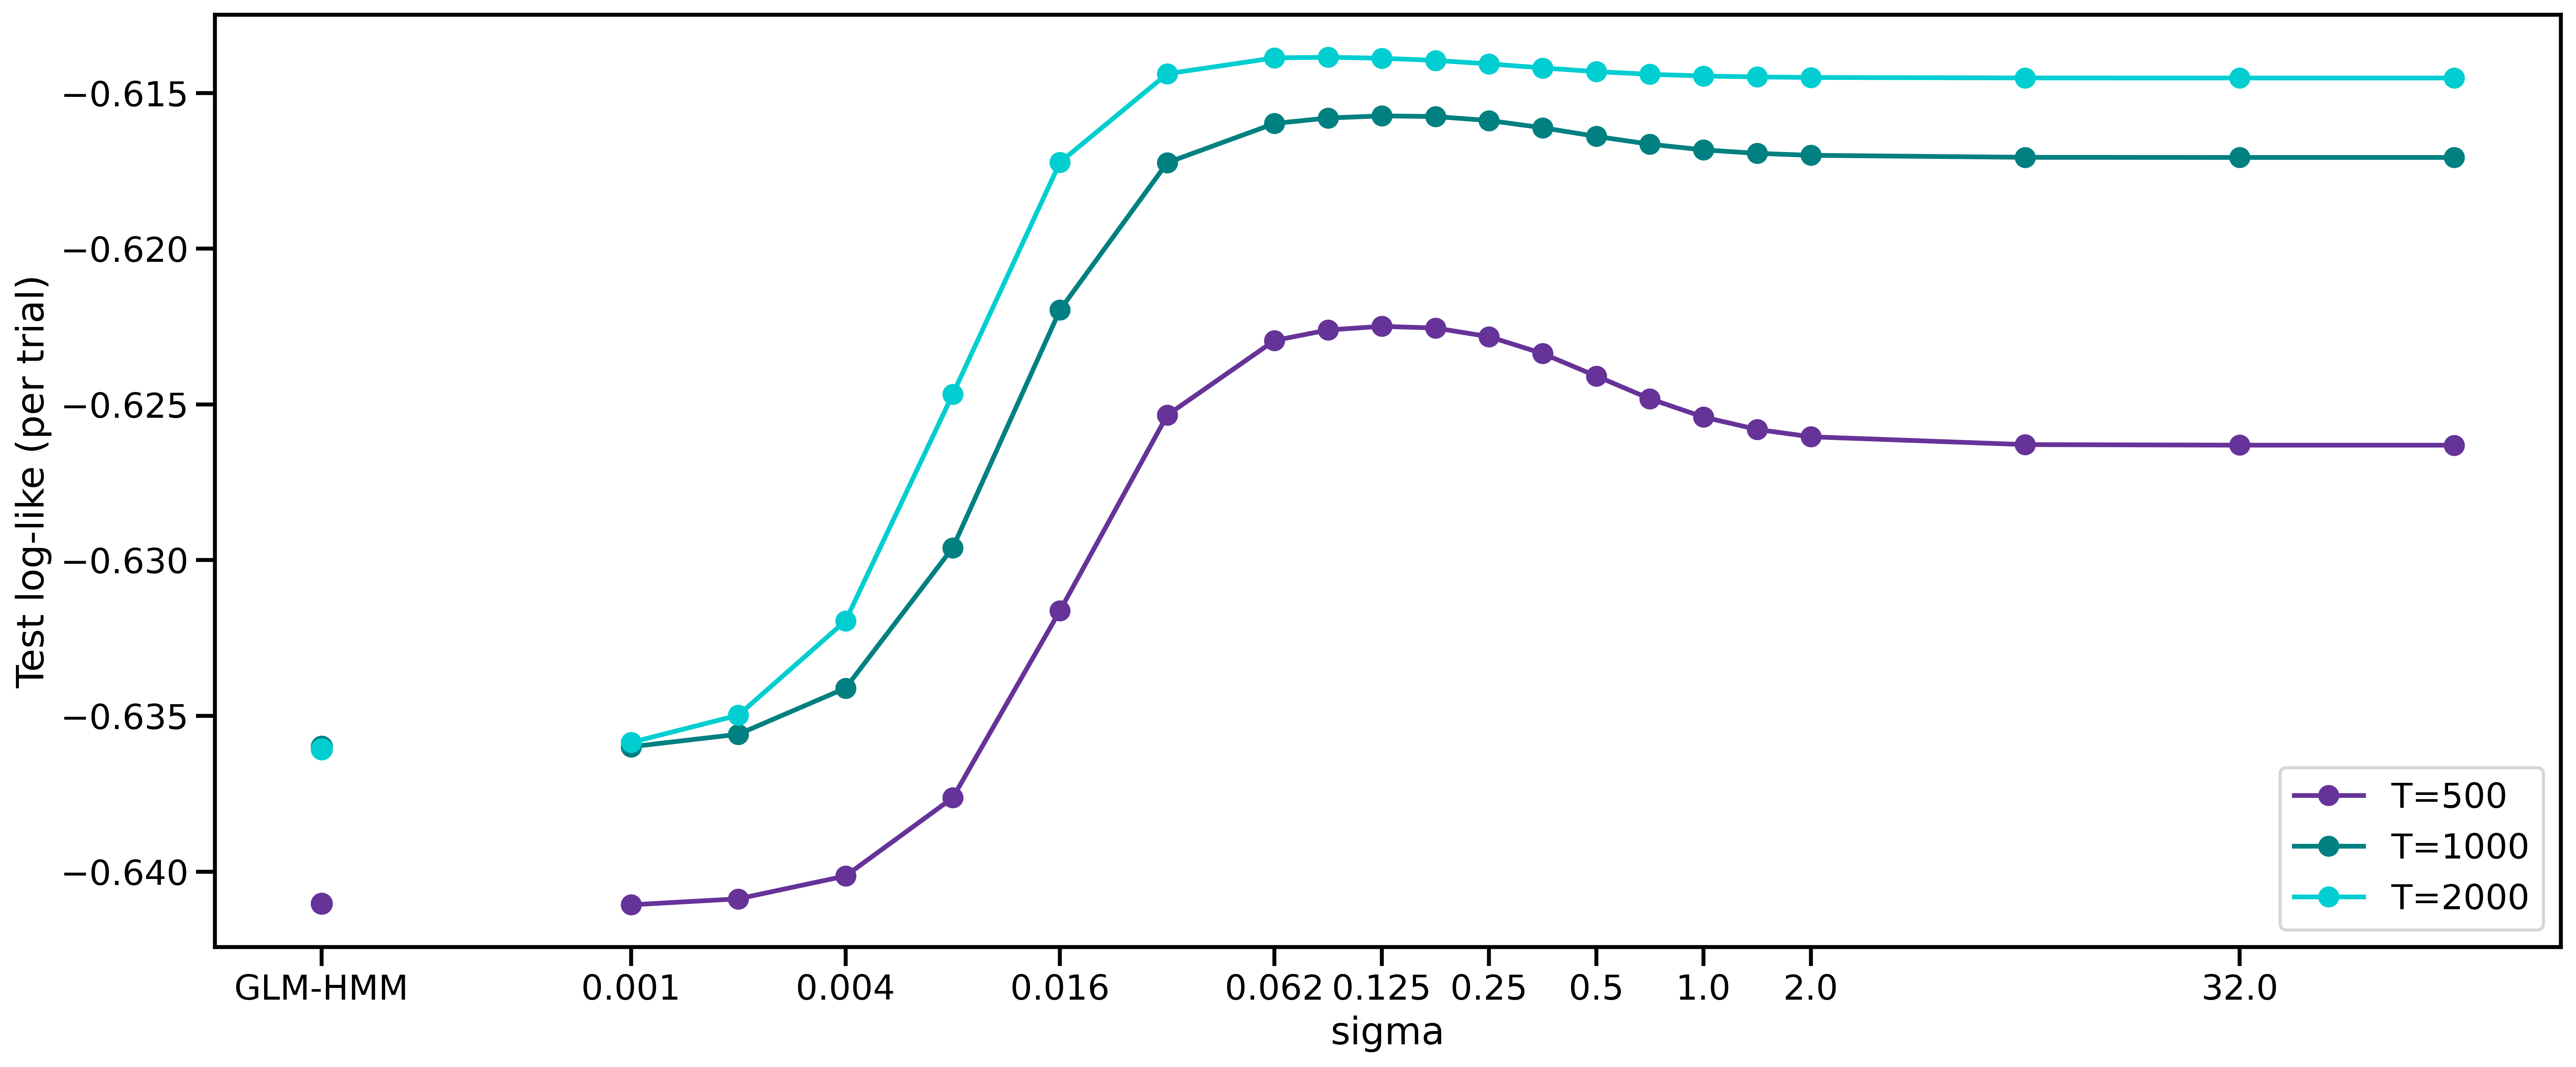

In [28]:
fig, axes = plt.subplots(1, figsize = (20,8), dpi=400)
K=2

T = 500
N = 20 * T
testLl = np.load(f'../data_M1/N={N}_{K}_testLl_CV_sigma1D_simulated_data.npy')
plot_testLl_CV_sigma(np.mean(testLl,0), sigmaList, f'T={T}', colormap[0], axes, linestyle='-o', alpha=1)

T = 1000
N = 20 * T
testLl = np.load(f'../data_M1/N={N}_{K}_testLl_CV_sigma1D_simulated_data.npy')
plot_testLl_CV_sigma(np.mean(testLl,0), sigmaList, f'T={T}', colormap[1], axes, linestyle='-o', alpha=1)

T = 2000
N = 20 * T
testLl = np.load(f'../data_M1/N={N}_{K}_testLl_CV_sigma1D_simulated_data.npy')
plot_testLl_CV_sigma(np.mean(testLl,0), sigmaList, f'T={T}', colormap[2], axes, linestyle='-o', alpha=1)

axes.set_ylabel('Test log-like (per trial)')
plt.savefig(f'../figures_M1/TestLl_vs_Sigma_T-effect.png', bbox_inches='tight', dpi=400)

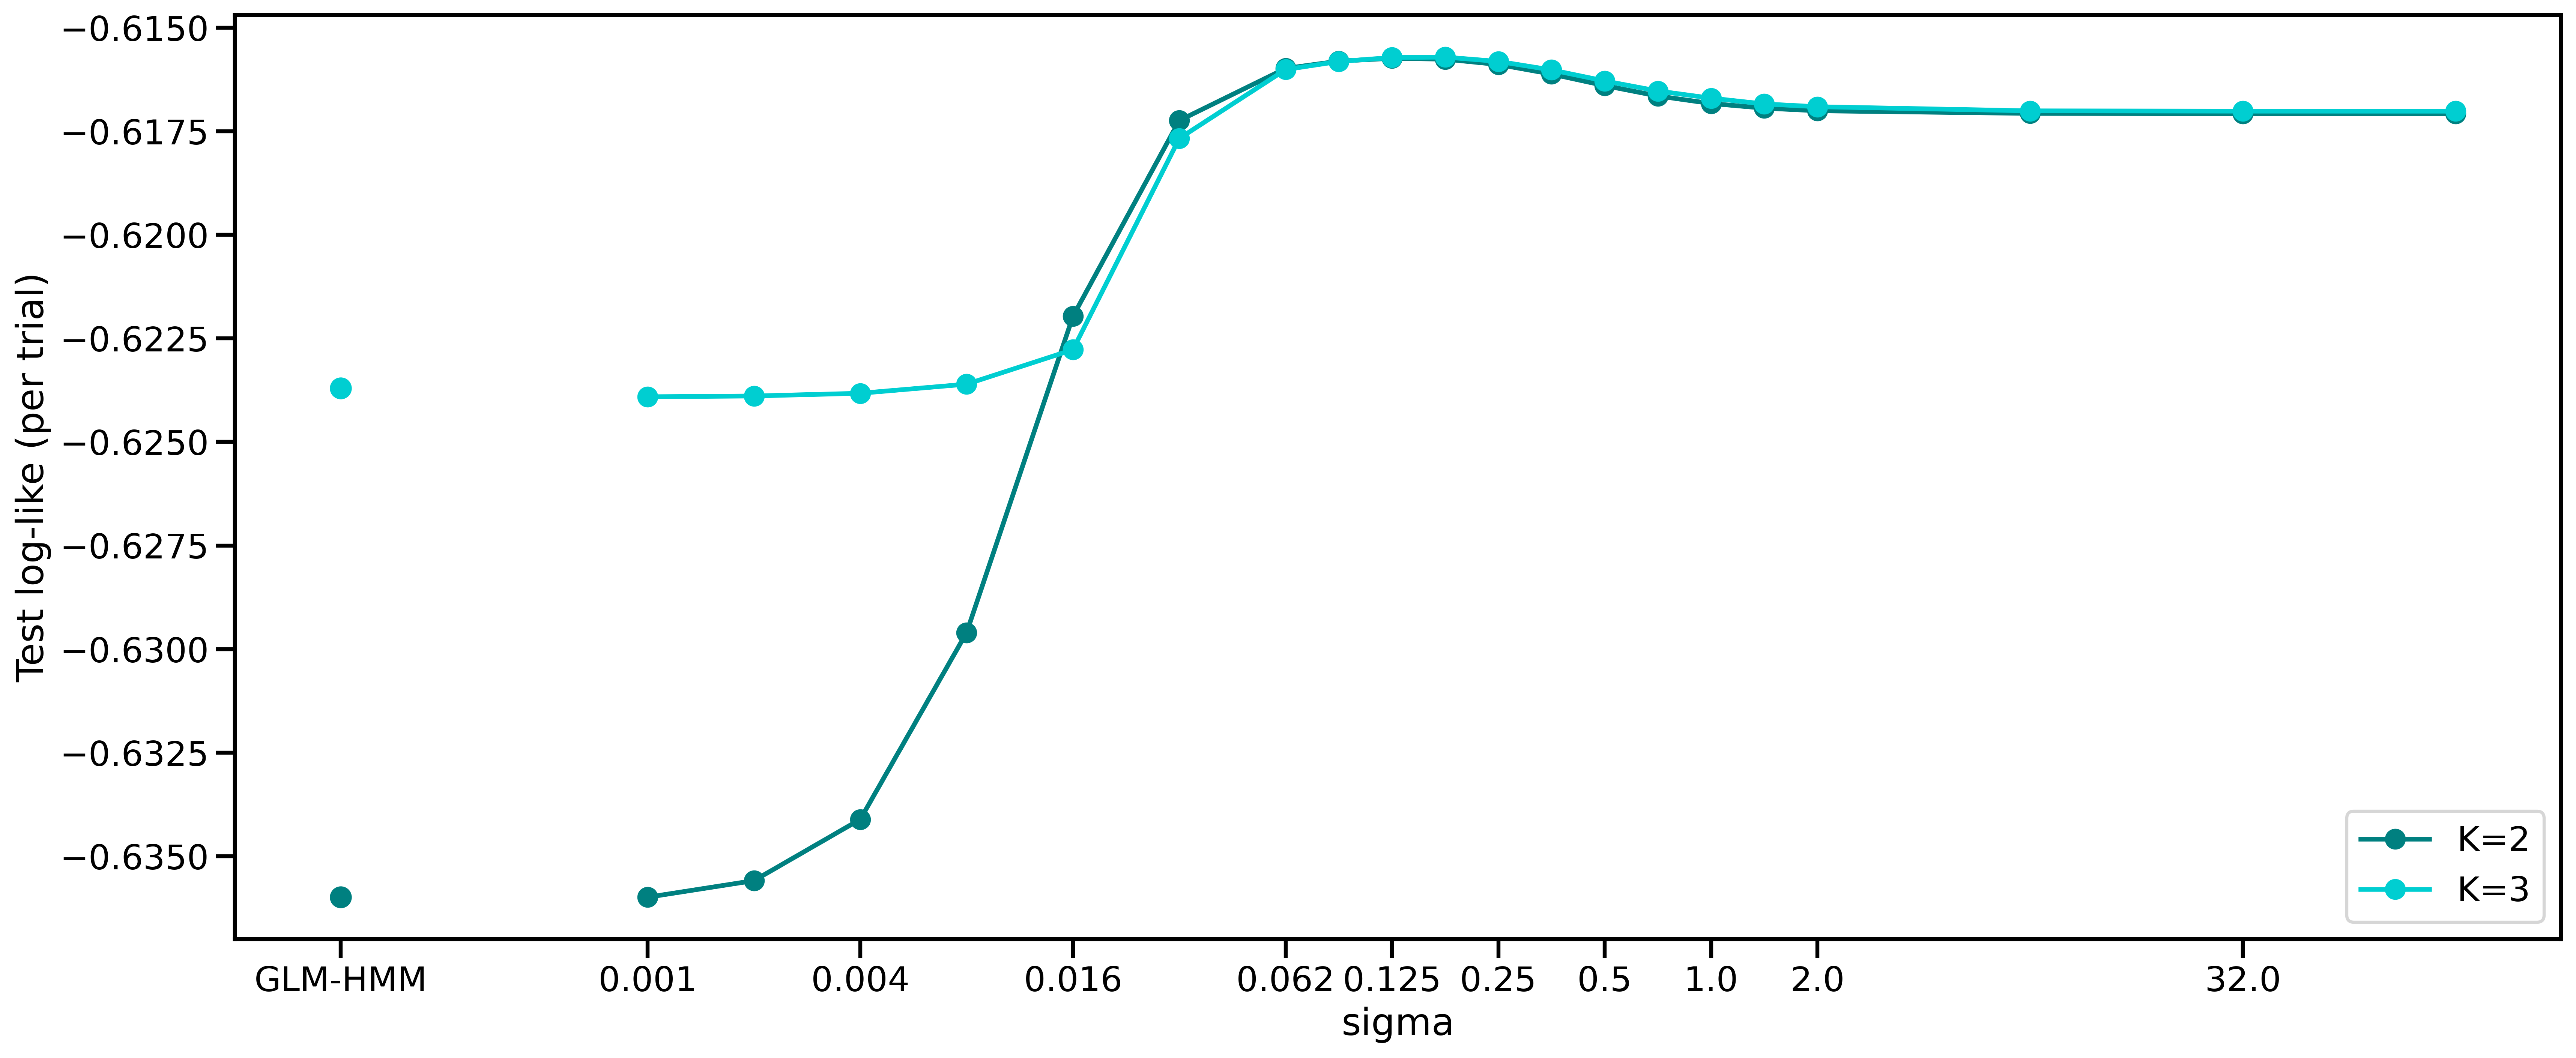

In [31]:
fig, axes = plt.subplots(1, figsize = (20,8), dpi=400)
T = 1000
N = S * T

# K = 1
# testLl = np.load(f'../data_M1/N={N}_{K}_testLl_CV_sigma1D_simulated_data_2-state.npy')
# plot_testLl_CV_sigma(np.mean(testLl,0), sigmaList, f'K={K}', colormap[0], axes, linestyle='-o', alpha=1)

K = 2
testLl = np.load(f'../data_M1/N={N}_{K}_testLl_CV_sigma1D_simulated_data.npy')
plot_testLl_CV_sigma(np.mean(testLl,0), sigmaList, f'K={K}', colormap[1], axes, linestyle='-o', alpha=1)

K = 3
testLl = np.load(f'../data_M1/N={N}_{K}_testLl_CV_sigma1D_simulated_data_2-state.npy')
plot_testLl_CV_sigma(np.mean(testLl,0), sigmaList, f'K={K}', colormap[2], axes, linestyle='-o', alpha=1)

axes.set_ylabel('Test log-like (per trial)')
plt.savefig(f'../figures_M1/TestLl_vs_Sigma_K-effect.png', bbox_inches='tight', dpi=400)